# Recurrent Inference Machine (RIM) on a toy problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the simulator and the data
The simulator is defined as $y=Ax + n$ where $A$ is a deterministic matrix and $n \sim \mathcal{N}(0,\sigma^2)$ with $\sigma$ known. The loss will then be defined to be $\mathcal{L}(x,y)=\frac{1}{2} x^T A^T A x - y^T A x$. To simulate an ill-conditioned problem, we choose $A^T A= \bigl( \begin{smallmatrix}0.1 & 0\\ 0 & 1\end{smallmatrix}\bigr)$, which gives $A=\bigl( \begin{smallmatrix}\sqrt{0.1} & 0\\ 0 & 1\end{smallmatrix}\bigr)$

### Constants

In [3]:
A = np.array([[np.sqrt(1),0],[0,1]])
sigma = 0.5

### Simulator

In [4]:
def simulate(x):
    return np.dot(A,x) + np.random.normal(0,sigma**2)

### Data

In [6]:
data_x = np.array([1,1])
data_y = simulate(data_x)

In [7]:
x_min = np.linalg.inv(A).dot(data_y)

### Loss and gradient

In [8]:
def loss(x,y):
    return 0.5 * x.T.dot(A.T).dot(A).dot(x) -  y.T.dot(A).dot(x)

In [9]:
def gradient(x,y):
    return A.T.dot(A.dot(x) - y)

In [11]:
loss(np.array([data_x[0], data_x[1]]),data_y)

-1.5301947846586272

### Visualization

In [12]:
xx = np.linspace(-6, 8, 200)
yy = np.linspace(-2, 4, 200)

X, Y = np.meshgrid(xx, yy)
grid = np.concatenate([X[:,:,np.newaxis], Y[:,:,np.newaxis]], axis=2)
Z = np.apply_along_axis(lambda x: loss(x,data_y), 2, grid)

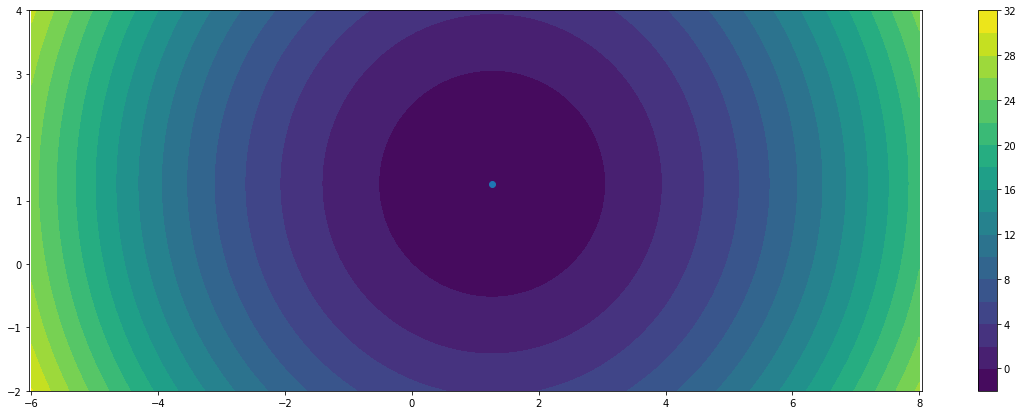

In [16]:
plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X, Y, Z, 20)
plt.colorbar()
plt.scatter(x_min[0], x_min[1])

## Gradient descent

In [17]:
x0 = np.array([-4,3], dtype='float64')
T = 60
lr = 0.6

In [18]:
xt = x0.copy()
list_xt = [x0]
for t in range(T):
    xt = xt - lr * gradient(xt, data_y)
    list_xt.append(xt)
list_xt = np.array(list_xt)

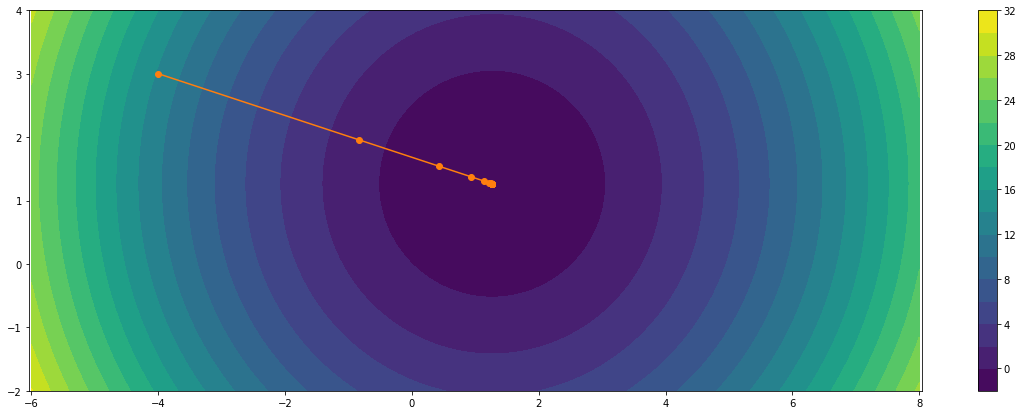

In [21]:
plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X, Y, Z, 20)
plt.colorbar();
plt.scatter(x_min[0], x_min[1])
plt.plot(list_xt[:,0], list_xt[:,1], color=colormap[1])
plt.scatter(list_xt[:,0], list_xt[:,1])

## RIM

In [22]:
def weight_loss(t, T):
#     return t/T
    return 1

In [23]:
class RIM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RIM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        
    def forward(self, x, hidden):
        input = Variable(torch.Tensor(np.concatenate([x.detach().numpy(), gradient(x.detach().numpy(), data_y)], 0).reshape(1, 1, 4)))
        out, hidden = self.rnn(input, hidden)
        return out.view(self.hidden_size), hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

In [24]:
rim = RIM(4,2)

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rim.parameters(), lr=0.1)

In [26]:
x0 = np.array([-3,3], dtype='float64')

tensor(1.00000e-04 *
       5.5330)


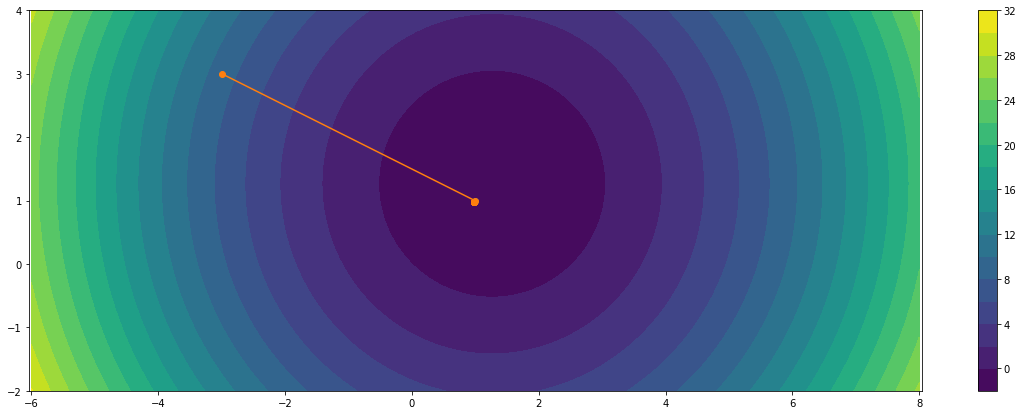

In [38]:
xt = Variable(torch.Tensor(x0))
st = rim.init_hidden()
loss = 0
T = 10
optimizer.zero_grad()
list_xt = [x0]

for t in range(T):
    xt, st = rim.forward(xt, st)
    loss = weight_loss(t,T) * criterion(xt, torch.Tensor(data_x))
    list_xt.append(xt.detach().numpy())
list_xt = np.array(list_xt)
loss.backward()
optimizer.step()
print(loss)

plt.rcParams['figure.figsize'] = (20,7)
plt.axis('equal')

plt.contourf(X, Y, Z, 20)
plt.colorbar();
plt.scatter(data_x[0], data_x[1])
plt.plot(list_xt[:,0], list_xt[:,1], color=colormap[1])
plt.scatter(list_xt[:,0], list_xt[:,1])